In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


def create_ticker_dict(ticker, change_in_retained, cash_to_debt, debt_to_equity, prefstock, buyback):
    return {
        ticker: {
            "Change in Retained Earnings": change_in_retained,
            "Cash-to-Debt difference": cash_to_debt,
            "Debt-to-Equity Ratio": debt_to_equity,
            "Preferred Stock Equity Exists": prefstock,
            "Buyback Detected": buyback,
        }
    }
def getBalanceSheet(t):
    ticker = yf.Ticker(t)
    balance = ticker.quarterly_balance_sheet
    return balance

def find_total_equity(b):
    common_stock_equity = b.loc["Common Stock Equity"] if "Common Stock Equity" in b.index else 0
    retained_earnings = b.loc["Retained Earnings"] if "Retained Earnings" in b.index else 0
    additional_paid_in_capital = b.loc["Additional Paid In Capital"] if "Additional Paid In Capital" in b.index else 0
    other_equity_adjustments = b.loc["Other Equity Adjustments"] if "Other Equity Adjustments" in b.index else 0
    treasury_shares = b.loc["Treasury Shares Number"] if "Treasury Shares Number" in b.index else 0
    
    # Calculate Total Equity
    total_equity = (common_stock_equity + retained_earnings +
                    additional_paid_in_capital + other_equity_adjustments)
    
    return total_equity.iloc[0]

def find_total_debt(b):
    try:
    # Initialize debt values with 0 if the index doesn't exist
        short_term_debt = b.loc["Current Liabilities"].iloc[0] if "Current Liabilities" in b.index else 0
        long_term_debt = b.loc["Total Non Current Liabilities Net Minority Interest"].iloc[0] if "Total Non Current Liabilities Net Minority Interest" in b.index else 0
        
        # Calculate Total Debt
        total_debt = short_term_debt + long_term_debt
        
        return total_debt

    except(e):
        print("error occured in finding total debt")

def visualise(data):
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    plt.plot(data.index, data, marker='o', linestyle='-', color='b')  # Plot with blue line and circle markers
    plt.title('Retained Earnings Over Time')  # Title of the plot
    plt.xlabel('Date')  # X-axis label
    plt.ylabel('Retained Earnings ($)')  # Y-axis label
    plt.grid(True)  # Enable grid for easier readability of the plot
    plt.xticks(rotation=45)  # Rotate date labels for better visibility
    plt.tight_layout()  # Adjust layout to not cut off any label or title
    plt.show()  # Display the plot

In [2]:
import requests
from bs4 import BeautifulSoup
import urllib.parse as urlparse

links = ["https://finviz.com/screener.ashx?v=111&f=sh_short_o30&r=21", 
         "https://finviz.com/screener.ashx?v=111&f=sh_short_o30",
         "https://finviz.com/screener.ashx?v=111&f=sh_short_o30&r=41"]
tickers = []

def get_ticker(a_tags):
    for tag in a_tags:
        href = tag.get('href')  # Use .get() to avoid KeyErrors if 'href' is missing
        if href and "quote.ashx" in href:
            parsed_href = urlparse.urlparse(href)
            query_params = urlparse.parse_qs(parsed_href.query)
            if 't' in query_params:
                ticker = query_params['t'][0]
                tickers.append(ticker)

def scrape(url):
    headers = {
        'Referer': 'https://www.google.com/', 
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        print("Data fetched successfully from:", url)
        soup = BeautifulSoup(response.content, 'html.parser')
        a_tags = soup.find_all('a', class_='tab-link')
        get_ticker(a_tags)
    else:
        print("Failed to fetch data from", url, "with status code:", response.status_code)

# Loop through all links and scrape them
for link in links:
    scrape(link)

# Print all collected tickers
print("Collected tickers:", tickers)


Data fetched successfully from: https://finviz.com/screener.ashx?v=111&f=sh_short_o30&r=21
Data fetched successfully from: https://finviz.com/screener.ashx?v=111&f=sh_short_o30
Data fetched successfully from: https://finviz.com/screener.ashx?v=111&f=sh_short_o30&r=41
Collected tickers: ['MNMD', 'MPW', 'NIVF', 'NOVA', 'OKUR', 'PALI', 'PHAT', 'PLCE', 'PRME', 'RILY', 'SANA', 'SAVA', 'SEDG', 'SMX', 'SYM', 'SYTA', 'TWG', 'VVPR', 'WOLF', 'WOOF', 'ABR', 'ACDC', 'ALT', 'ATNF', 'BMEA', 'BTDR', 'BYND', 'CGBS', 'CHPT', 'CRK', 'CRVO', 'ENVX', 'EVGO', 'GOGO', 'GRPN', 'IBRX', 'JFBR', 'KSS', 'LAES', 'LDTC', 'WOOF']


In [3]:
def dd(ticker):
    balance = getBalanceSheet(ticker)
    
    # Ensure required data exists
    try:
        total_cash = balance.loc['Cash Cash Equivalents And Short Term Investments']
        total_debt = balance.loc['Total Debt'] if 'Total Debt' in balance.index else find_total_debt(balance)
        total_liabilities = balance.loc['Total Liabilities Net Minority Interest']
        retained_earnings = balance.loc['Retained Earnings']
    except KeyError as e:
        print(f"Error: Missing required data in {ticker}'s balance sheet: {e}")
        return None

    # Process retained earnings
    retained = retained_earnings.reset_index()
    retained.columns = ['Date', 'Retained Earnings']
    retained = retained.set_index('Date')  # Assign the result back to `retained`

    # Define helper functions
    def recentRetained(retained):
        try:
            if 'Retained Earnings' in retained.columns and len(retained) > 1:
                return retained.iloc[0]['Retained Earnings'] / retained.iloc[1]['Retained Earnings']
            else:
                return None  # Fallback if data is insufficient
        except ZeroDivisionError:
            print("Error: Division by zero occurred in change_in_retained calculation.")
            return None
        except Exception as e:
            print(f"Unexpected error in change_in_retained calculation: {e}")
            return None

    def CashDebtDiff(total_cash, total_debt):
        try:
            return (total_cash - total_debt).iloc[0]
        except Exception as e:
            print(f"Unexpected error in cashdebt calculation: {e}")
            return None

    def liabilityEquityRatio(balance):
        try:
            total_equity = find_total_equity(balance)
            if total_equity != 0:
                return total_liabilities.iloc[0] / total_equity
            else:
                return None  # Prevent division by zero
        except ZeroDivisionError:
            print("Error: Division by zero occurred in debt-to-equity calculation.")
            return None
        except Exception as e:
            print(f"Unexpected error in debt-to-equity calculation: {e}")
            return None

    def DetectPreferredStock(balance):
        try:
            # Check for Preferred Stock Equity in the index
            return 'Preferred Stock' in balance.index
        except Exception as e:
            print(f"Unexpected error in prefstock check: {e}")
            return False
            
    def DetectTreasuryShares(balance):
        try:
            # Check for Treasury Shares and ensure the column exists and has data
            if 'Treasury Shares Number' in balance.index and not balance.loc['Treasury Shares Number'].isna().all():
                return balance.loc['Treasury Shares Number'].iloc[0] > 0
            else:
                return False  # Default to False if data is missing
        except Exception as e:
            print(f"Unexpected error in buyback calculation: {e}")
            return False

    # Execute helper functions and collect results
    change_in_retained = recentRetained(retained)
    cashdebt = CashDebtDiff(total_cash, total_debt)
    debttoeq = liabilityEquityRatio(balance)
    prefstock = DetectPreferredStock(balance)
    buyback = DetectTreasuryShares(balance)

    # Return results as a dictionary for the ticker
    return create_ticker_dict(ticker, change_in_retained, cashdebt, debttoeq, prefstock, buyback)


In [4]:
l=[]
for i in tickers:
    dueDiligence = dd(i)
    if dueDiligence is not None:
        l.append(dueDiligence)

l

Error: Missing required data in ABR's balance sheet: 'Cash Cash Equivalents And Short Term Investments'
Error: Missing required data in CGBS's balance sheet: 'Retained Earnings'


[{'MNMD': {'Change in Retained Earnings': 1.0390464939763848,
   'Cash-to-Debt difference': 270973000.0,
   'Debt-to-Equity Ratio': 0.10979698161278142,
   'Preferred Stock Equity Exists': False,
   'Buyback Detected': False}},
 {'MPW': {'Change in Retained Earnings': 1.3617008138252342,
   'Cash-to-Debt difference': -9076770000.0,
   'Debt-to-Equity Ratio': 0.9005683615212502,
   'Preferred Stock Equity Exists': True,
   'Buyback Detected': False}},
 {'NIVF': {'Change in Retained Earnings': 0.5129308092470768,
   'Cash-to-Debt difference': -278449.0,
   'Debt-to-Equity Ratio': 0.2612298414799998,
   'Preferred Stock Equity Exists': False,
   'Buyback Detected': False}},
 {'NOVA': {'Change in Retained Earnings': 0.048559874046861976,
   'Cash-to-Debt difference': -8030068000.0,
   'Debt-to-Equity Ratio': 2.866626060980484,
   'Preferred Stock Equity Exists': False,
   'Buyback Detected': False}},
 {'OKUR': {'Change in Retained Earnings': 1.876723987083022,
   'Cash-to-Debt difference':

In [5]:
getBalanceSheet('LAZR').loc['Total Debt']


2024-09-30    583399000.0
2024-06-30    664623000.0
2024-03-31    665932000.0
2023-12-31    660661000.0
2023-09-30    636645000.0
2023-06-30            NaN
2023-03-31            NaN
Name: Total Debt, dtype: object

In [6]:
def array_to_dataframe(data):
    # Flatten the array of dictionaries
    flattened_data = {ticker: metrics for item in data for ticker, metrics in item.items()}
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(flattened_data, orient='index')
    return df

# Convert the data
df = array_to_dataframe(l)

# Display the DataFrame
print(df)

      Change in Retained Earnings  Cash-to-Debt difference  \
MNMD                     1.039046             2.709730e+08   
MPW                      1.361701            -9.076770e+09   
NIVF                     0.512931            -2.784490e+05   
NOVA                     0.048560            -8.030068e+09   
OKUR                     1.876724             7.600300e+07   
PALI                     1.027007             7.683000e+06   
PHAT                     1.077587             1.582690e+08   
PLCE                     0.901941            -6.958310e+08   
PRME                     1.088650             1.342790e+08   
RILY                     1.235608            -2.091355e+09   
SANA                     1.040060             1.029230e+08   
SAVA                     1.079935                      NaN   
SEDG                    -1.459653            -7.967000e+07   
SMX                      0.808104            -3.907000e+06   
SYM                      1.001887            -4.611120e+08   
SYTA    

In [7]:
df


,Change in Retained Earnings,Cash-to-Debt difference,Debt-to-Equity Ratio,Preferred Stock Equity Exists,Buyback Detected
MNMD,1.039046,2.709730e+08,0.109797,False,False
MPW,1.361701,-9.076770e+09,0.900568,True,False
NIVF,0.512931,-2.784490e+05,0.261230,False,False
NOVA,0.048560,-8.030068e+09,2.866626,False,False
OKUR,1.876724,7.600300e+07,0.024501,False,False
PALI,1.027007,7.683000e+06,0.206651,True,False
PHAT,1.077587,1.582690e+08,-1.534233,True,True
PLCE,0.901941,-6.958310e+08,-9.343865,True,True
PRME,1.088650,1.342790e+08,0.378042,False,False
RILY,1.235608,-2.091355e+09,10.282422,True,False


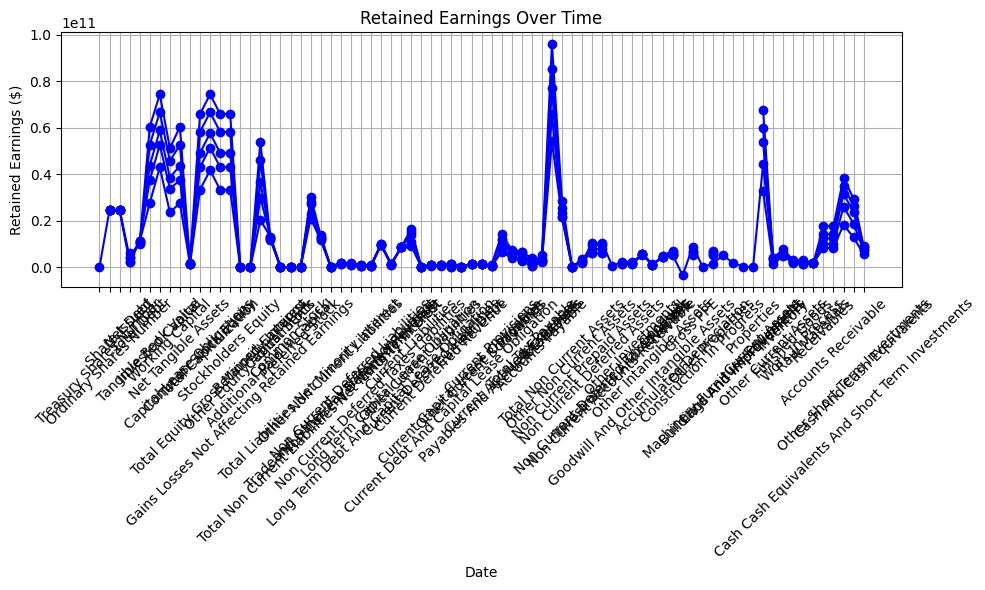

In [8]:
visualise(getBalanceSheet('NVDA'))

In [9]:
getBalanceSheet('NVDA')

,2024-10-31,2024-07-31,2024-04-30,2024-01-31,2023-10-31,2023-07-31,2023-04-30
Treasury Shares Number,NaN,NaN,NaN,NaN,0.0,NaN,NaN
Ordinary Shares Number,24508000000.0,24562000000.0,24598341970.0,24640000000.0,24660000000.0,NaN,NaN
Share Issued,24508000000.0,24562000000.0,24598341970.0,24640000000.0,24660000000.0,NaN,NaN
Net Debt,NaN,NaN,2123000000.0,2429000000.0,4187000000.0,3922000000.0,5875000000.0
Total Debt,10225000000.0,10015000000.0,11237000000.0,11056000000.0,11027000000.0,NaN,NaN
...,...,...,...,...,...,...,...
Receivables,17693000000.0,14132000000.0,12365000000.0,9999000000.0,8309000000.0,NaN,NaN
Accounts Receivable,17693000000.0,14132000000.0,12365000000.0,9999000000.0,8309000000.0,NaN,NaN
Cash Cash Equivalents And Short Term Investments,38487000000.0,34800000000.0,31438000000.0,25984000000.0,18281000000.0,NaN,NaN
Other Short Term Investments,29380000000.0,26237000000.0,23851000000.0,18704000000.0,12762000000.0,NaN,NaN


In [10]:
import yfinance as yf

import yfinance as yf

def get_screen(ticker_symbol):
    def categorize_market_cap(market_cap):
        if market_cap >= 200e9:
            return "mega"
        elif 10e9 <= market_cap < 200e9:
            return "large"
        elif 2e9 <= market_cap < 10e9:
            return "mid"
        elif 300e6 <= market_cap < 2e9:
            return "small"
        elif 50e6 <= market_cap < 300e6:
            return "micro"
        elif market_cap < 50e6:
            return "nano"
        else:
            return "Unknown"
    try:
        # Download the ticker information
        ticker = yf.Ticker(ticker_symbol)
        info = ticker.info

        # Extract the industry, sector, and market cap
        industry = info.get('industry', 'N/A')
        sector = info.get('sector', 'N/A')
        market_cap = info.get('marketCap','N/A')

        return [f"cap_{categorize_market_cap(market_cap)}",f"ind_{industry.lower().replace(" ", "")}", f'sec_{sector.lower().replace(" ", "")}']

    except Exception as e:
        return ["Error", "Error", f"Error retrieving data: {e}"]

# Example usage
ticker_symbol = "KULR"  # Replace with the ticker of your choice

screen = get_screen(ticker_symbol)
print(screen)

def construct_finviz_url(filters,view_mode = 111):
    base_url = "https://finviz.com/screener.ashx"
    query_params = {
        'v': view_mode,       # View mode (e.g., 111 for descriptive view)
        'f': ','.join(filters)  # Comma-separated filters
    }
    
    # Construct the full URL
    full_url = f"{base_url}?{urlencode(query_params)}"
    return full_url

construct_finviz_url(screen)


['cap_small', 'ind_electroniccomponents', 'sec_technology']


NameError: name 'urlencode' is not defined

In [11]:
import requests
from bs4 import BeautifulSoup
import urllib.parse as urlparse


def get_ticker(a_tags):
    tickers = []
    for tag in a_tags:
        href = tag.get('href')  # Use .get() to avoid KeyErrors if 'href' is missing
        if href and "quote.ashx" in href:
            parsed_href = urlparse.urlparse(href)
            query_params = urlparse.parse_qs(parsed_href.query)
            if 't' in query_params:
                ticker = query_params['t'][0]
                tickers.append(ticker)
    return tickers


def help(url):
    headers = {
        'Referer': 'https://www.google.com/', 
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        print("Data fetched successfully from:", url)
        soup = BeautifulSoup(response.content, 'html.parser')
        a_tags = soup.find_all('a', class_='tab-link')
        return get_ticker(a_tags)
    else:
        print("Failed to fetch data from", url, "with status code:", response.status_code)

def scrape(link):
    return help(link)








In [12]:
from urllib.parse import urlencode


# Generate the URL
finviz_url = construct_finviz_url(screen)

print(f"Constructed URL: {finviz_url}")


Constructed URL: https://finviz.com/screener.ashx?v=111&f=cap_small%2Cind_electroniccomponents%2Csec_technology


In [13]:
tickers = scrape(finviz_url)

Data fetched successfully from: https://finviz.com/screener.ashx?v=111&f=cap_small%2Cind_electroniccomponents%2Csec_technology


In [14]:
def sample(tl, ticker):
    def getIndex(l, ticker):
        # Find the index of the ticker in the list
        for index, value in enumerate(l):
            if value == ticker:
                return index
        return None  # Return None if the ticker is not found

    # Get the index of the ticker in the list
    n = getIndex(tl, ticker)

    if n is None:
        raise ValueError(f"Ticker '{ticker}' not found in the list")

    # Determine the slice bounds to get 10 tickers
    start = max(0, n - 4)
    end = min(len(tl), n + 5)

    # Extract the base slice
    result = tl[start:end]

    # Pad the list if there aren't enough elements
    while len(result) < 10:
        if start > 0:  # Add elements to the front if possible
            start -= 1
            result = [tl[start]] + result
        elif end < len(tl):  # Add elements to the back if possible
            result.append(tl[end])
            end += 1
        else:
            break  # Exit if no more elements are available to pad
    return result

# Example usage
result = sample(tickers, 'OUST')
print(result)


['BELFB', 'BHE', 'CTS', 'DAKT', 'KN', 'KULR', 'LYTS', 'MEI', 'OUST', 'ROG']


In [15]:
len(tickers)

11

In [16]:
import yfinance as yf
import matplotlib.pyplot as plt

def plot_operating_margins(operating_margins, highlight_ticker):
    # Filter out None values
    filtered_margins = {ticker: margin for ticker, margin in operating_margins.items() if margin is not None}
    
    tickers = list(filtered_margins.keys())
    margins = list(filtered_margins.values())
    
    # Define bar colors
    colors = ['green' if ticker == highlight_ticker else 'skyblue' for ticker in tickers]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(tickers, margins, color=colors)
    
    # Customize x-axis labels
    plt.xticks(
        range(len(tickers)),
        [f"{ticker}\n{margin:.2f}%" for ticker, margin in zip(tickers, margins)],
        rotation=0
    )
    
    # Labels and title
    plt.xlabel('Tickers and Operating Margins')
    plt.ylabel('Operating Margin (%)')
    plt.title('Operating Margins of Companies')
    plt.tight_layout()
    plt.show()

def plotom(t, tickers):
    operating_margins = get_operating_margins(tickers)
    print(operating_margins)  # To verify the margins
    plot_operating_margins(operating_margins, highlight_ticker=t)

# Example usage
plotom('KULR', tickers)


NameError: name 'get_operating_margins' is not defined

In [ ]:
import yfinance as yf
import pandas as pd

def calculate_revenue_growth(tickers):
    growth_data = {}
    
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            # Fetch financials (Income Statement)
            financials = stock.financials
            
            # Extract revenue (Total Revenue is often labeled as 'Total Revenue')
            revenue = financials.loc['Total Revenue']
            
            # Convert revenue to a DataFrame for easier handling
            revenue = revenue.sort_index(ascending=True)  # Sort by date
            
            # Ensure there are at least 4 years of data for 3-year growth
            if len(revenue) < 4:
                growth_data[ticker] = {
                    '1_year_growth': None,
                    '3_year_growth': None
                }
                continue
            
            # Calculate 1-year and 3-year revenue growth
            one_year_growth = ((revenue[-1] - revenue[-2]) / revenue[-2]) * 100
            three_year_growth = ((revenue[-1] - revenue[-4]) / revenue[-4]) * 100
            
            # Store the data
            growth_data[ticker] = {
                '1_year_growth': one_year_growth,
                '3_year_growth': three_year_growth
            }
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            growth_data[ticker] = {
                '1_year_growth': None,
                '3_year_growth': None
            }
    
    return growth_data

# Example usage
growth_data = calculate_revenue_growth(tickers)

# Convert to DataFrame for better readability
growth_df = pd.DataFrame(growth_data).T
print(growth_df)


In [ ]:
growth_df

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

def plot_revenue_growth(growth_data):
    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(growth_data).T
    df = df.dropna()  # Drop rows with missing data
    
    # Extract data for plotting
    tickers = df.index
    one_year_growth = df['1_year_growth']
    three_year_growth = df['3_year_growth']
    
    # Create a grouped bar chart
    x = np.arange(len(tickers))  # X-axis positions
    width = 0.35  # Bar width
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width / 2, one_year_growth, width, label='1-Year Growth', color='skyblue')
    bars2 = ax.bar(x + width / 2, three_year_growth, width, label='3-Year Growth', color='lightgreen')
    
    # Add labels, title, and legend
    ax.set_xlabel('Tickers')
    ax.set_ylabel('Revenue Growth (%)')
    ax.set_title('1-Year and 3-Year Revenue Growth by Company')
    ax.set_xticks(x)
    ax.set_xticklabels(tickers)
    ax.legend()
    
    # Add data labels on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')
    
    add_labels(bars1)
    add_labels(bars2)
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Example usage
growth_data = calculate_revenue_growth(tickers)
plot_revenue_growth(growth_data)


In [ ]:
!pip install prettyprint

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def get_operating_margins(tickers):
    operating_margins = {}
    
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            
            # Extract operating margin
            margin = info.get('operatingMargins')
            if margin is not None:
                operating_margins[ticker] = margin * 100  # Convert to percentage
            else:
                operating_margins[ticker] = None  # Handle missing data
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            operating_margins[ticker] = None

    return operating_margins




In [24]:
from pprint import pprint
def get_revenue(tickers):
    revenues = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        try:
            # Fetch the income statement
            income_statement = stock.financials
            
            # Get the revenue (total revenue) for the latest period
            latest_revenue = income_statement.loc['Total Revenue'].iloc[0]
            revenues[ticker] = latest_revenue
        except Exception as e:
            # Append None if there's an issue
            revenues.append({ticker: None})
    return revenues

def get_operating_margins(tickers):
    operating_margins = {}
    
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            
            # Extract operating margin
            margin = info.get('operatingMargins')
            if margin is not None:
                operating_margins[ticker] = margin * 100  # Convert to percentage
            else:
                operating_margins[ticker] = None  # Handle missing data
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            operating_margins[ticker] = None

    return operating_margins


def calculate_price_to_sales(tickers):
    ps_ratios = {}
    
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            
            # Fetch market capitalization and revenue
            market_cap = info.get('marketCap')  # Market capitalization
            total_revenue = info.get('totalRevenue')  # Total revenue
            
            # Calculate Price-to-Sales ratio
            if market_cap is not None and total_revenue is not None and total_revenue > 0:
                ps_ratios[ticker] = market_cap / total_revenue
            else:
                ps_ratios[ticker] = None  # Handle missing or invalid data
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            ps_ratios[ticker] = None
    
    return ps_ratios

def calculate_revenue_growth(tickers):
    growth_data = {}
    
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            # Fetch financials (Income Statement)
            financials = stock.financials
            
            # Extract revenue (Total Revenue is often labeled as 'Total Revenue')
            revenue = financials.loc['Total Revenue']
            
            # Convert revenue to a DataFrame for easier handling
            revenue = revenue.sort_index(ascending=True)  # Sort by date
            
            # Ensure there are at least 4 years of data for 3-year growth
            if len(revenue) < 4:
                growth_data[ticker] = {
                    '1_year_growth': None,
                    '3_year_growth': None
                }
                continue
            
            # Calculate 1-year and 3-year revenue growth
            one_year_growth = ((revenue[-1] - revenue[-2]) / revenue[-2]) * 100
            three_year_growth = ((revenue[-1] - revenue[-4]) / revenue[-4]) * 100
            
            # Store the data
            growth_data[ticker] = {
                '1_year_growth': one_year_growth,
                '3_year_growth': three_year_growth
            }
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            growth_data[ticker] = {
                '1_year_growth': None,
                '3_year_growth': None
            }
    pprint(growth_data)
    return growth_data

def tabulate(ps,om,growth,r): 
    data=[]
    for ticker, metric_value in om.items():
        data.append({
            'Ticker': ticker,
            'operating_margins': metric_value,
            'p/s':ps[ticker],
            'revenue':r[ticker],
            '1-Year Growth': growth[ticker]['1_year_growth'],
            '3-Year Growth': growth[ticker]['3_year_growth']
        })
    return data


data = tabulate(ps=calculate_price_to_sales(tickers),om = get_operating_margins(tickers),growth = calculate_revenue_growth(tickers),r= get_revenue(tickers))

def rank(data):
    rankedData = data.copy()
    keys_to_rank = [key for key in rankedData[0].keys() if key != 'Ticker']
    
    # Rank each metric
    for key in keys_to_rank:
        # Sort the data by the current key
        sorted_data = sorted(rankedData, key=lambda x: x[key], reverse=True)
        
        # Assign rankings
        for rank, item in enumerate(sorted_data, 1):
            item[f"{key}_rank"] = rank
    
    # Pair value with its rank for each metric
    for item in rankedData:
        for key in keys_to_rank:
            item[key] = (item[key], item[f"{key}_rank"])
    
    # Remove the extra rank fields to clean up
    for item in rankedData:
        for key in keys_to_rank:
            del item[f"{key}_rank"]
    pprint(rankedData)
    return rankedData
    

data

C:\Users\thoma\AppData\Local\Temp\ipykernel_18300\1272550913.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  one_year_growth = ((revenue[-1] - revenue[-2]) / revenue[-2]) * 100
C:\Users\thoma\AppData\Local\Temp\ipykernel_18300\1272550913.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  three_year_growth = ((revenue[-1] - revenue[-4]) / revenue[-4]) * 100
C:\Users\thoma\AppData\Local\Temp\ipykernel_18300\1272550913.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

{'ALNT': {'1_year_growth': 15.03932499383683,
          '3_year_growth': 57.797509640190455},
 'BELFB': {'1_year_growth': -2.204107710861421,
           '3_year_growth': 37.366431143201275},
 'BHE': {'1_year_growth': -1.6406642204237838,
         '3_year_growth': 38.27544370037762},
 'CTS': {'1_year_growth': -6.210414930759676,
         '3_year_growth': 29.796305292100755},
 'DAKT': {'1_year_growth': 8.470874944974515,
          '3_year_growth': 69.71514398391811},
 'KN': {'1_year_growth': -7.466980515234732,
        '3_year_growth': -7.418552924244406},
 'KULR': {'1_year_growth': 146.08427205095634,
          '3_year_growth': 1475.4354811567957},
 'LYTS': {'1_year_growth': -5.5014396986593,
          '3_year_growth': 48.80232690772214},
 'MEI': {'1_year_growth': -5.518819938962361,
         '3_year_growth': 2.4356617647058822},
 'OUST': {'1_year_growth': 102.97594384459772,
          '3_year_growth': 340.53639441388066},
 'ROG': {'1_year_growth': -6.466227347611203,
         '3_year_g

[{'Ticker': 'ALNT',
  'operating_margins': 5.506,
  'p/s': 0.7373918993375865,
  'revenue': 578634000.0,
  '1-Year Growth': 15.03932499383683,
  '3-Year Growth': 57.797509640190455},
 {'Ticker': 'BELFB',
  'operating_margins': 9.94,
  'p/s': 1.9741277818867529,
  'revenue': 639813000.0,
  '1-Year Growth': -2.204107710861421,
  '3-Year Growth': 37.366431143201275},
 {'Ticker': 'BHE',
  'operating_margins': 4.394,
  'p/s': 0.6162322585236774,
  'revenue': 2838976000.0,
  '1-Year Growth': -1.6406642204237838,
  '3-Year Growth': 38.27544370037762},
 {'Ticker': 'CTS',
  'operating_margins': 16.760998999999998,
  'p/s': 3.11820994115089,
  'revenue': 550422000.0,
  '1-Year Growth': -6.210414930759676,
  '3-Year Growth': 29.796305292100755},
 {'Ticker': 'DAKT',
  'operating_margins': 10.047,
  'p/s': 0.9812451234537479,
  'revenue': 818083000.0,
  '1-Year Growth': 8.470874944974515,
  '3-Year Growth': 69.71514398391811},
 {'Ticker': 'KN',
  'operating_margins': 14.175001000000002,
  'p/s': 2.

In [21]:
import matplotlib.pyplot as plt

def plot_price_to_sales(data, highlight_ticker):
    tickers = [item['Ticker'] for item in data if item.get('p/s') is not None]
    ps_values = [item['p/s'] for item in data if item.get('p/s') is not None]
    
    # Define bar colors
    colors = ['green' if ticker == highlight_ticker else 'skyblue' for ticker in tickers]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    bars = plt.bar(tickers, ps_values, color=colors)
    
    # Add labels and title
    plt.xlabel('Tickers')
    plt.ylabel('Price-to-Sales Ratio')
    plt.title('Price-to-Sales Ratios of Companies')
    
    # Add data labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_price_to_sales(data, highlight_ticker='KULR')


NameError: name 'data' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_revenue_growth(data, highlight_ticker=None):
    """
    Plots 1-Year and 3-Year revenue growth for a list of companies,
    with the option to highlight a specific ticker in green.
    
    Args:
        data (list of dict): List of dictionaries containing company information.
        highlight_ticker (str): The ticker symbol to highlight in green (optional).
    """
    # Filter out entries with missing growth data
    filtered_data = [item for item in data if item.get('1-Year Growth') is not None and item.get('3-Year Growth') is not None]
    
    # Extract data for plotting
    tickers = [item['Ticker'] for item in filtered_data]
    one_year_growth = [item['1-Year Growth'] for item in filtered_data]
    three_year_growth = [item['3-Year Growth'] for item in filtered_data]
    
    # Define colors for bars
    colors_one_year = ['lightgreen' if ticker == highlight_ticker else 'skyblue' for ticker in tickers]
    colors_three_year = ['green' if ticker == highlight_ticker else 'blue' for ticker in tickers]
    
    # Create a grouped bar chart
    x = np.arange(len(tickers))  # X-axis positions
    width = 0.35  # Bar width
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width / 2, one_year_growth, width, label='1-Year Growth', color=colors_one_year)
    bars2 = ax.bar(x + width / 2, three_year_growth, width, label='3-Year Growth', color=colors_three_year)
    
    # Add labels, title, and legend
    ax.set_xlabel('Tickers')
    ax.set_ylabel('Revenue Growth (%)')
    ax.set_title('1-Year and 3-Year Revenue Growth by Company')
    ax.set_xticks(x)
    ax.set_xticklabels(tickers)
    ax.legend()
    
    # Add data labels on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')
    
    add_labels(bars1)
    add_labels(bars2)
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


# Plot the data and highlight a specific ticker
plot_revenue_growth(data, highlight_ticker='KULR')


In [ ]:
import matplotlib.pyplot as plt

def plot_operating_margins(data, highlight_ticker):
    """
    Plots the operating margins for a list of companies with a specific ticker highlighted.
    
    Args:
        data (list of dict): List of dictionaries containing company information.
        highlight_ticker (str): The ticker symbol to highlight in the plot.
    """
    # Filter out entries with missing operating margins
    filtered_data = [item for item in data if item.get('operating_margins') is not None]
    
    # Extract tickers and operating margins
    tickers = [item['Ticker'] for item in filtered_data]
    margins = [item['operating_margins'] for item in filtered_data]
    
    # Define bar colors
    colors = ['green' if ticker == highlight_ticker else 'skyblue' for ticker in tickers]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(tickers, margins, color=colors)
    
    # Customize x-axis labels
    plt.xticks(
        range(len(tickers)),
        [f"{ticker}\n{margin:.2f}%" for ticker, margin in zip(tickers, margins)],
        rotation=0
    )
    
    # Labels and title
    plt.xlabel('Tickers and Operating Margins')
    plt.ylabel('Operating Margin (%)')
    plt.title('Operating Margins of Companies')
    plt.tight_layout()
    plt.show()



plot_operating_margins(data, highlight_ticker='KULR')



In [ ]:
rank(data)

In [53]:
def plot_rev(data,highlight):
    def readable(i):
        m=""
        if i>1e12:
            m="T"
            n= round(i/1e12*10)
        elif i>1e9:
            m="B"
            n= round(i/1e9*10)
        elif i> 1e6:
             m="M"
             n= round(i/1e6*10)
        else:
             m="k"
             n=round(i/1e3*10)
        return str(n)+m
    clean = [item for item in data if item.get('revenue') is not None]
    readable_revs = [readable(item['revenue']) for item in clean]
    revs = [item['revenue'] for item in clean]
    colors = ['green' if highlight==item['Ticker'] else 'skyblue' for item in data]
    plt.figure(figsize = (10,6))
    plt.bar(tickers,revs,color = colors)
    plt.xticks(
        range(len(tickers)),
        [f"{ticker}\n{margin}" for ticker, margin in zip(tickers, readable_revs)],
        rotation=0
    )
    plt.xlabel('Revenues and tickers')
    plt.ylabel('Revenues (%)')
    plt.title('Revenues')
    plt.tight_layout()
    plt.show()
    
    

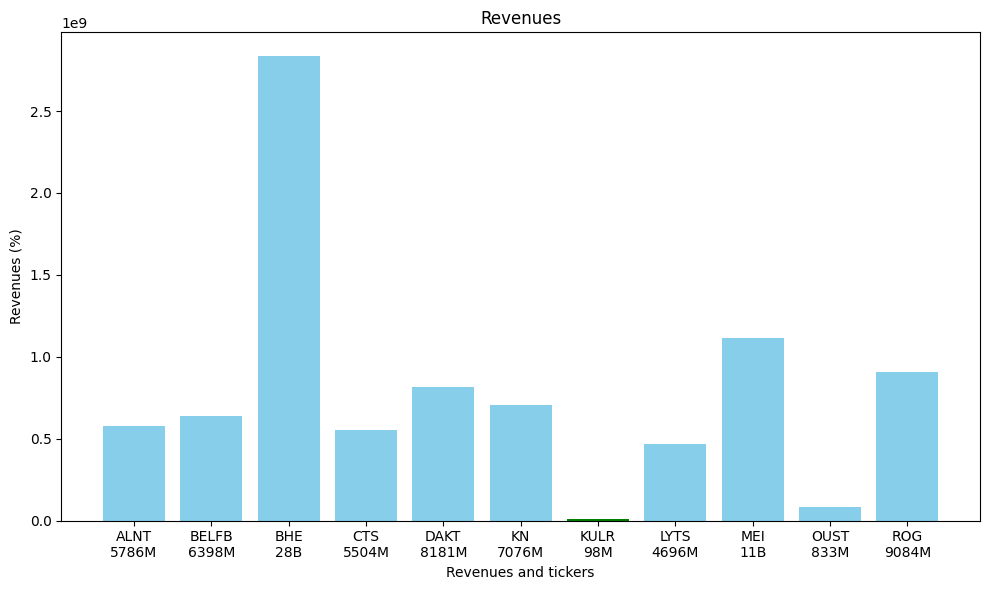

In [54]:
plot_rev(data,'KULR')